## Run training on CMLE and test the online prediction service

In [145]:
import os

REGION = ""
TFVERSION = "1.8"
BUCKET = ""
DATA_DIR = ""
MODEL_DIR = ""
MODEL_NAME = "" # no hyphens in model name
MODEL_VERSION = ""
JOBDIR = "gs://$BUCKET/$MODEL_DIR/job"
JOBNAME= "keras_mnist_$(date -u +%y%m%d_%H%M%S)"


os.environ['REGION'] = REGION
os.environ['TFVERSION'] = TFVERSION
os.environ['BUCKET'] = BUCKET
os.environ['DATA_DIR'] = DATA_DIR
os.environ['MODEL_DIR'] = MODEL_DIR
os.environ['MODEL_NAME'] = MODEL_NAME
os.environ['MODEL_VERSION'] = MODEL_VERSION
os.environ['JOBDIR'] = JOBDIR
os.environ['JOBNAME'] = JOBNAME



## Run the training job. Adjust train_steps as needed

In [ ]:
!gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.main \
   --package-path="$(pwd)/trainer" \
   --job-dir=$JOBDIR \
   --staging-bucket=gs://$BUCKET \
   --runtime-version=$TFVERSION \
   -- \
   --data_dir=gs://$BUCKET/$DATA_DIR \
   --model_dir=gs://$BUCKET/$MODEL_DIR \
   --export_dir=gs://$BUCKET/$MODEL_DIR \
   --train_steps=1000

In [ ]:
!gcloud ml-engine jobs stream-logs $JOBNAME

## Export the model location

In [184]:
%%bash --out MODEL_LOCATION

MODEL_LOCATION=$(gsutil ls gs://$BUCKET/$MODEL_DIR/export/ | tail -1)
echo $MODEL_LOCATION

In [ ]:
print(MODEL_LOCATION)

## Create the model in CMLE

In [ ]:
!gcloud ml-engine models create $MODEL_NAME --regions $REGION

## Create the versioned model with the model location

In [ ]:
!gcloud ml-engine versions create $MODEL_VERSION --model $MODEL_NAME --runtime-version $TFVERSION --origin $MODEL_LOCATION

## Generate sample data to test

Extracting mnist/data/train-images-idx3-ubyte.gz
Extracting mnist/data/train-labels-idx1-ubyte.gz
Extracting mnist/data/t10k-images-idx3-ubyte.gz
Extracting mnist/data/t10k-labels-idx1-ubyte.gz


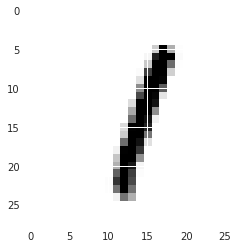

In [197]:
import json, codecs
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

HEIGHT=28
WIDTH=28

mnist = input_data.read_data_sets('mnist/data', one_hot=True, reshape=False)
IMGNO=5 #CHANGE THIS to get different images
jsondata = {'X': mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH).tolist()}
json.dump(jsondata, codecs.open('test.json', 'w', encoding='utf-8'))
plt.imshow(mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH));

In [198]:
!gcloud ml-engine predict \
   --model=$MODEL_NAME \
   --version=$MODEL_VERSION \
   --json-instances=./test.json

DENSE_3
[[0.08580759912729263, 0.12363497167825699, 0.09535027295351028, 0.09899786859750748, 0.10415774583816528, 0.10815949738025665, 0.09799060225486755, 0.10332376509904861, 0.08739430457353592, 0.09518339484930038]]
